In [158]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.transforms as mtrans
import scipy.stats as stats
import pymc3 as pm
import pandas as pd
import arviz as az
from causalgraphicalmodels import CausalGraphicalModel

# Chapter 11 - GOD SPIKED THE INTEGERS

11E1. If an event has probability 0.35, what are the log-odds of this event?

Answer: Simply using the definition of log odds as $log(\frac{p}{1-p})$ we can compute

In [2]:
np.log(0.35/(1-0.35))

-0.6190392084062235

11E2. If an event has log-odds 3.2, what is the probability of this event?

Answer: Trivially rearranging the log-odds we $p = \frac{1}{1 + exp(-l)}$, where we let l denote the log-odds

In [3]:
1/(1+np.exp(-3.2))

0.9608342772032357

11E3. Suppose that a coefficient in a logistic regression has value 1.7. What does this imply about
the proportional change in odds of the outcome?

Answer: In a linear logistic regression, we have something like 

$ logit(p) = \beta  \mathbb{1}_x $

The odds is the exponential of the logit. 

We can compute the change in the odds due to the indicator term not being killed, by the exponentiating $\beta$. This is discussed in the overthinking box on "Proportional odds and relative risk"

In [4]:
np.exp(1.7)

5.4739473917272

11E4. Why do Poisson regressions sometimes require the use of an offset? Provide an example.

Answer: The offset term arises due to differences in the "exposure" period used for count data. For instance, if two car companies wish to store data on the number of cars they sell, then company A may store the number of cars the cell per week, whilst company B records the number of cars they sell per month. The time interval which is used to record the data needs to be accounted for if we wish to compare the sales between company A and company B.

11M1. As explained in the chapter, binomial data can be organized in aggregated and disaggregated
forms, without any impact on inference. But the likelihood of the data does change when the data are
converted between the two formats. Can you explain why?

Answer: In binomial data, each outcome can be one of two values. As such, binomial data can be represented as a sequence, each element representing which outcome occured. For example $(1,2,1,1,1)$. If the probability of outcomes 1 & 2 are $p_1, p_2$ respectively, then the likelihood of this particular sequence is $p_1p_2p_1p_1p_1 = p_1^4p_2$. However, as this is binomial data, the particular order of the outcome is inconsequential, as all the events were independent. Moreover, an often missed point about binomial data is that we are at liberty to store our list of outcomes in any order we like, irrespective of the order in which the events actually occured. That is, I can relabel all the events and give it to you in a new order and you've lost no information relative to myself. Thus the only thing that can differentiate any two outcome sequences of a given length is the number of successes and fails. 

To put the above onto a mathemtical footing, inference only depends on the posterior distribution, not the likelihood, and having binomial data aggregateed or disaggregated in now way alters the posterior. Let's presume we made 5 observations above. We can let $p_1 = p, p_2=(1-p)$ 

$ P(p|D) = \frac{P(D|p)P(p)}{P(D)} = \frac{p^4(1-p)P(p)}{P(D)} = \frac{p^4(1-p)P(p)}{\int p^4(1-p)P(p) dp} = \frac{{ 5 \choose 4}p^4(1-p)P(p)}{\int  {5 \choose 4} p^4(1-p)P(p) dp} $

As can be seen, whether we aggregate the binomial data or not, it makes no difference to the posterior inference.

11M2. If a coefficient in a Poisson regression has value 1.7, what does this imply about the change
in the outcome?

Answer: This is a fairly ambiguous question, as it depends on the link function you use. However, for simplicity let's proceed with the log link function as the book does.

$ T $ ~ Poission($\lambda_i$)

$log \lambda_i = \beta x$

That is the log of the rate is modelled linearly. If we increase x by 1 unit, then the value of $\lambda$ changes as follows. 

Let $x_2 = x_1 +1$. Then,

$log(\lambda_2) - log(\lambda_1) = \beta \implies \lambda_2 = \lambda_1 e^\beta$

That is, increasing the predictor variable x by 1 increases the expected value by a factor of $e^\beta$

We can visualise this change alters the likelihood/outcome distributions by plotting them. Let's set  $x_1 = 3, x_2=4$

In [5]:
from scipy.stats import poisson

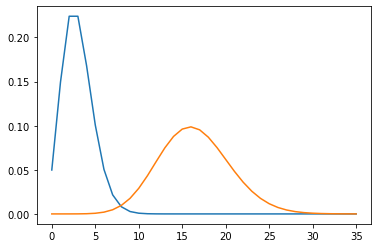

In [6]:
x = np.linspace(0,35,36)

plt.plot(x, poisson.pmf(k =x,mu = 3))
plt.plot(x, poisson.pmf(k =x,mu = 3*np.exp(1.7)))

11M3. Explain why the logit link is appropriate for a binomial generalized linear model.

Answer: In any experiment with a binomial random variable there are two outcomes with probabilities p and (1-p). Using the logit link ensures that $ p \in (0,1) $ regardless of the value of the predictor variables. That's the primary reason. That is, logit(p) = linear stuff $ \implies $ p = sigmoid(linear stuff), and the sigmoid always lies between zero and one, except at $ \pm \infty$

There is the added benefit that it's a monotonically increasing function, which allows you to anticapate to some extent how the model will actually behave as your predictor variables increase thus aiding your interpretation of the parameters. To see why this is important, imagine using a sinusoidal link function. This is also constrained to lie between 0 and 1, however interpreting it would be gastly. it's also not invertible which would also cause problems with interpretation that the logit link wouldn't give us. 

11M4. Explain why the log link is appropriate for a Poisson generalized linear model.

Answer: The rate parameter in a poisson model must be positive. The log link ensures this is satisfied. Moreover, the monotone property of the exponential is also very helpful.

11M5. What would it imply to use a logit link for the mean of a Poisson generalized linear model?
Can you think of a real research problem for which this would make sense?

Answer: The logit link would constrain the rate to lie between zero and one.

If you had a research problem where the mean rate was constrained to be between zero and one this would make sense. One could imagine something like the yearly birthrate of females in a certain age bracket in a country. One cannot imagine the mean birthrate of female exceeding 1 for reasons of biology. However, the Poisson model is still appropriate as some women give birth to quadrouplets, which is rare and is modelled as such under a Poisson model with rate less than 1.

This does make one wonder why you wouldn't just bake this belief into your prior instead of using a link function to impose this. However, this could be a form of regularization. For instance, we have such overwhelming knowledge of biology that we know we don't want the birthrate of individual women to exceed 1 in our model. If this was just in a prior, we might overfit to a fluke data set with many women who gave birth to quadrouplets. By placing placing this constraint in the link function we're insisting that no amount of data could ever change our mind about the upper bound on the mean number of births that individual women can have. At first glance this might seem like it contravenes something like Cromwell's rule (for the uninitiated see the link below), the notion that we should never assign probabilities of 0 and 1. However, using such a link function is reasonable. If all of a sudden the biology of the human race alters drastically, for technological reasons say, then what you should actually do is come up with a new model, and not insist that your model fit for all circumstances. Bayesian inference is about thinking about everything your model might need to perform well. It is not about producing a model that will perform well when thinking about everything


https://en.wikipedia.org/wiki/Cromwell%27s_rule#:~:text=Cromwell's%20rule%2C%20named%20by%20statistician,2%20equaling%204%20or%205.


11M6. State the constraints for which the binomial and Poisson distributions have maximum entropy. Are the constraints different at all for binomial and Poisson? Why or why not?

Answer: There are probably many ways to go and concoct an interpretation for this. However the most straight forward is to re-iterate that the binomial distribution is the maximum entropy distribution for a series of n trials, each trial having a one of two outcomes denoted by 0 and 1, and each trial having an expected outcome of p.

The Poisson is simply the case when n $\rightarrow \infty$

11M7. Use quap to construct a quadratic approximate posterior distribution for the chimpanzee
model that includes a unique intercept for each actor, m11.4 (page 330). Compare the quadratic
approximation to the posterior distribution produced instead from MCMC. Can you explain both
the differences and the similarities between the approximate and the MCMC distributions? Relax the
prior on the actor intercepts to Normal(0,10). Re-estimate the posterior using both ulam and quap.
Do the differences increase or decrease? Why?

In [7]:
#load the data
chimps = pd.read_csv("./data/chimpanzees.csv", delimiter=";")

In [8]:
#zero index the actor variables to make things "pythonic"
chimps["actor_index"] = chimps["actor"] - 1

The treatment conditions are straight from the book:

(1) prosoc_left= 0 and condition= 0: Two food items on right and no partner.

(2) prosoc_left= 1 and condition= 0: Two food items on left and no partner.

(3) prosoc_left= 0 and condition= 1: Two food items on right and partner present.

(4) prosoc_left= 1 and condition= 1: Two food items on left and partner present.

We'll need to index these conditions in the data frame. We will set this to "treat_ind" in the data frame.

In [9]:
states = chimps[["prosoc_left","condition"]].drop_duplicates().reset_index() #get all four unique treatment conditions in an array
states["treat_ind"] = states.index # create an column to use as the index
chimps = pd.merge(chimps,states, "left", on=["prosoc_left","condition"]) #put these details into the chimps dataframe

In [10]:
chimps

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left,actor_index,index,treat_ind
0,1,NaN,0,1,2,0,1,0,0,0,0
1,1,NaN,0,1,4,0,0,1,0,0,0
2,1,NaN,0,1,6,1,0,0,0,2,1
3,1,NaN,0,1,8,0,1,0,0,0,0
4,1,NaN,0,1,10,1,1,1,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
499,7,4.0,1,6,64,1,1,1,6,38,3
500,7,6.0,1,6,66,1,1,1,6,38,3
501,7,3.0,1,6,68,0,0,1,6,36,2
502,7,7.0,1,6,70,0,0,1,6,36,2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


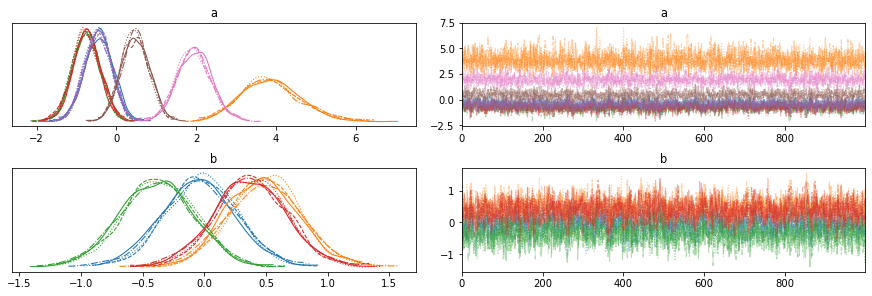

In [77]:
#lets run the model

with pm.Model() as m_11_4:
    a = pm.Normal("a", mu = 0, sigma = 1.5, shape = 7)
    b  = pm.Normal("b", mu = 0, sigma = 0.5, shape = 4)
    logitp = a[chimps.actor_index] + b[chimps.treat_ind]
    sigmoid = pm.Deterministic("sigmoid", pm.math.invlogit(logitp))
    y = pm.Bernoulli("y",sigmoid, observed=chimps.pulled_left )
    
    #get the quadratic approximation info
    approx_mean = pm.find_MAP()
    Hess = pm.find_hessian(approx_mean, vars=[a,b])
    
    #run MCMC
    m_11_4_sample = pm.sample(draws= 1000, chains = 4)
    pm.traceplot(m_11_4_sample, ["a","b"])

The MCMC chains look healthy for the model. The sample plots also indicate that the posteriors look approximately normal for this model. This indicates that the quadratic approximation probably perform reasonably well. Let's check this by comparing the QUAP and MCMC values of the posterior side by side.

In [82]:
var_cov = np.linalg.inv(Hess)#the variance covariance matrix
MCMC_interval = pm.summary(m_11_4_sample,var_names=["a","b"], hdi_prob=0.95)[["hdi_2.5%", "hdi_97.5%"]]#these are bounds
QUAP_interval = np.sqrt(np.diagonal(var_cov)) #these are standard deviations

/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


All of the sampling chains above look healthy here, indicating there were no obvious problems with MCMC sampling

In [80]:
np.append(sample["a"].mean(axis=0),sample["b"].mean(axis=0)).shape

(4,)

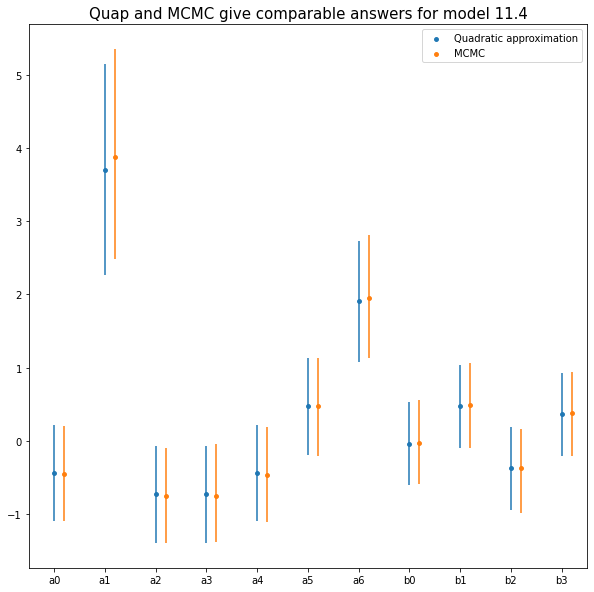

In [83]:

x = [ "a" + str(i) for i in range(7)] + [ "b" + str(i) for i in range(4)]

fig, ax = plt.subplots(figsize=(10,10))

#plot the QUAP
y = np.append(approx_mean["a"],approx_mean["b"])
ax.scatter(x , y, s = 15 , label="Quadratic approximation" )
#add +/- 2 std error bars to the quap
ax.errorbar(x, y, QUAP_interval*2 ,fmt=" ")

#create an offset for visual appeal and plot the MCMC approximation of the posterior
tr = mtrans.offset_copy(ax.transData, fig=fig, x=10, y=0, units='points')
y = np.append(m_11_4_sample["a"].mean(axis=0),m_11_4_sample["b"].mean(axis=0))
ax.scatter(x ,y , s = 15, label="MCMC",transform=tr)
#error array
error = np.append((y - MCMC_interval.values[:,0].T ),( MCMC_interval.values[:,1].T - y)).reshape(2,-1)
ax.errorbar(x,y, yerr = error, transform=tr,fmt=" ")

plt.title("Quap and MCMC give comparable answers for model 11.4", size = 15)
plt.legend()
plt.show()

In [ ]:
np.append(sample["a"].mean(axis=0),sample["b"].mean(axis=0))

Both models perform comparably to one another and approximate the similar posteriors. As stated above, this is reasonable as the MCMC posteriorsn actually appear to be fairly normal. The MCMC intervals also appear to be fairly symmetric, even thought this was in no way imposed on the visualisation. This symmetry is a consequence of the posterior look normal. 

Now let's look to see what happens when we run the model with broader priors on the intercept.

INFO (theano.gof.compilelock): Refreshing lock /home/aidan/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.10-x86_64-3.8.5-64/lock_dir/lock


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 96 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


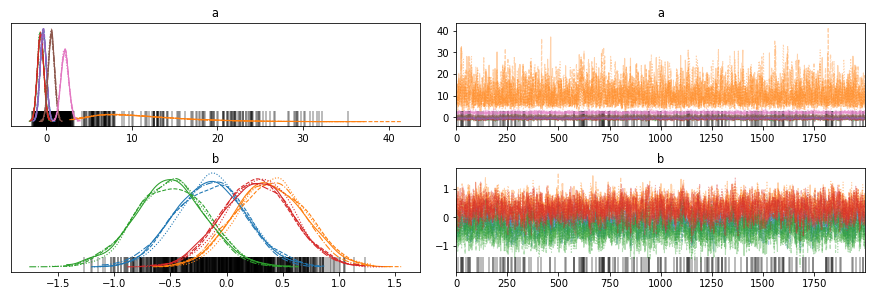

In [84]:
#lets run the model

with pm.Model() as m_11_4_asig10:
    a = pm.Normal("a", mu = 0, sigma = 10, shape = 7)
    b  = pm.Normal("b", mu = 0, sigma = 0.5, shape = 4)
    logitp = a[chimps.actor_index] + b[chimps.treat_ind]
    sigmoid = pm.Deterministic("sigmoid", pm.math.invlogit(logitp))
    y = pm.Bernoulli("y",sigmoid, observed=chimps.pulled_left )
    
    #get the quadratic approximation info
    approx_mean = pm.find_MAP()
    Hess = pm.find_hessian(approx_mean, vars=[a,b])
    
    #run MCMC
    sample = pm.sample(draws= 2000, chains = 4)
    pm.traceplot(sample, ["a","b"])

In [85]:
var_cov = np.linalg.inv(Hess)#the variance covariance matrix
MCMC_interval = pm.summary(sample,var_names=["a","b"], hdi_prob=0.95)[["hdi_2.5%", "hdi_97.5%"]]#these are bounds
QUAP_interval = np.sqrt(np.diagonal(var_cov)) #these are standard deviations

/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


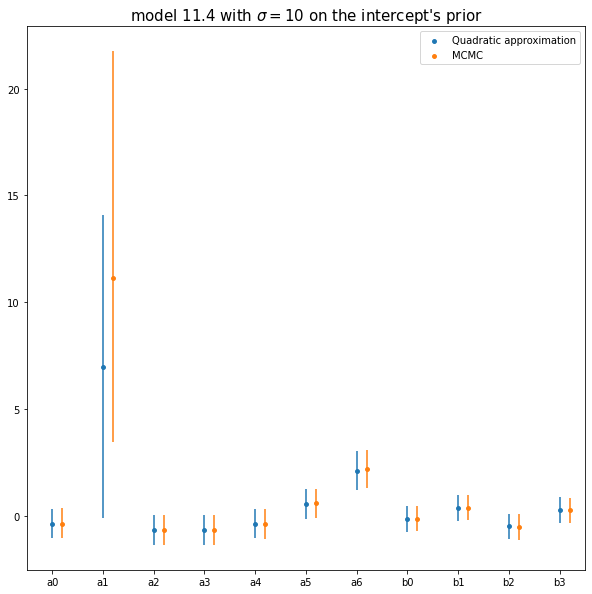

In [86]:
fig, ax = plt.subplots(figsize=(10,10))

#plot the QUAP
y = np.append(approx_mean["a"],approx_mean["b"])
ax.scatter(x , y, s = 15 , label="Quadratic approximation" )
#add +/- 2 std error bars to the quap
ax.errorbar(x, y, QUAP_interval*2 ,fmt=" ")

#create an offset for visual appeal and plot the MCMC approximation of the posterior
tr = mtrans.offset_copy(ax.transData, fig=fig, x=10, y=0, units='points')
y = np.append(sample["a"].mean(axis=0),sample["b"].mean(axis=0))
ax.scatter(x ,y , s = 15, label="MCMC",transform=tr)
#error array
error = np.append((y - MCMC_interval.values[:,0].T ),( MCMC_interval.values[:,1].T - y)).reshape(2,-1)
ax.errorbar(x,y, yerr = error, transform=tr,fmt=" ")

plt.title("model 11.4 with $\sigma = 10$ on the intercept's prior", size = 15)
plt.legend()
plt.show()

In [331]:
1/(1+np.exp(-5))

0.9933071490757153

This model cannot handle the second chimp's behaviour. If you recheck the book, chimp number 2 is the chimp that pulled the left leaver every single time in the experiment. Putting the really flat $\sigma$ prior on the intercept translates to the model being fairly convinced that extreme outcomes will occur on the outcome scale. When a predictor is highly predicive of the outcome in logistic regression, it's inherently hard to find to fit that parameter. This is becuase sigmoid(a) ~ 1 for a > 5. That is, whether a is  5 or 50, this implies roughly similar predictions, and it's hard to distinguish them with only 20 examples. Without a regularizing prior the model has a hard time fitting. This could be due to MCMC failing to sample this posterior effectively when the prior is so large.

11M8. Revisit the data(Kline) islands example. This time drop Hawaii from the sample and refit
the models. What changes do you observe?


In [349]:
kline = pd.read_csv("./data/Kline.csv", delimiter=";")

In [350]:
#drop Hawaii
kline = kline[ kline.culture != "Hawaii"]

In [351]:
kline["log_pop"] = np.log(kline["population"])
kline["cont_idx"] = kline.contact.astype("category").cat.codes # create the contact index

In [352]:
kline

,culture,population,contact,total_tools,mean_TU,log_pop,cont_idx
0,Malekula,1100,low,13,3.2,7.003065,1
1,Tikopia,1500,low,22,4.7,7.313220,1
2,Santa Cruz,3600,low,24,4.0,8.188689,1
3,Yap,4791,high,43,5.0,8.474494,0
4,Lau Fiji,7400,high,33,5.0,8.909235,0
5,Trobriand,8000,high,19,4.0,8.987197,0
6,Chuuk,9200,high,40,3.8,9.126959,0
7,Manus,13000,low,28,6.6,9.472705,1
8,Tonga,17500,high,55,5.4,9.769956,0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.


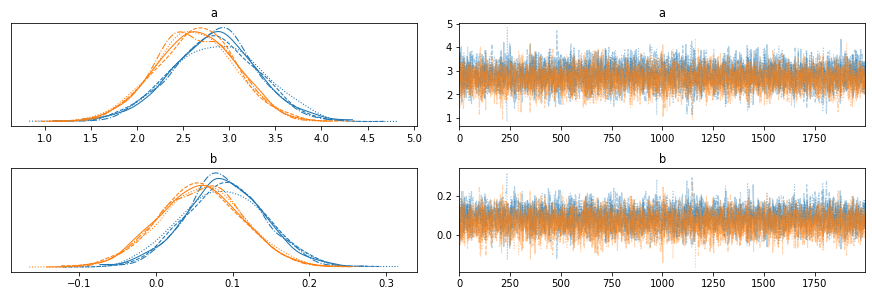

In [360]:
#define the model

with pm.Model() as m_11_10:
    a = pm.Normal("a", mu = 3, sigma = 0.5, shape = 2)
    b  = pm.Normal("b", mu = 0, sigma = 0.2, shape = 2)
    loglam = a[kline.cont_idx] + b[kline.cont_idx]*kline.log_pop
    lam = pm.Deterministic("sigmoid", pm.math.exp(loglam))
    y = pm.Poisson("y",lam, observed=kline.total_tools )
    
    #get the quadratic approximation info
    approx_mean = pm.find_MAP()
    Hess = pm.find_hessian(approx_mean, vars=[a,b])
    
    #run MCMC
    sample = pm.sample(draws= 2000, chains = 4,start=approx_mean)
    pm.traceplot(sample, ["a","b"])

In [393]:
x = np.linspace(6.9,10,20)


/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


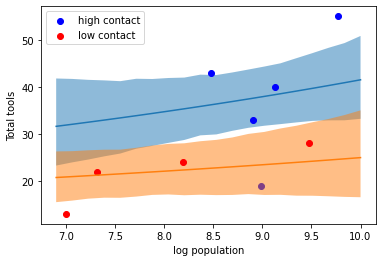

In [422]:
temp_df = kline[kline.contact == "high"]
#y = np.exp(sample["a"][:,0].mean() + np.outer(x,sample["b"][:,0].mean()))
y = np.exp(sample["a"][:,0] + np.outer(x,sample["b"][:,0]))
interval = az.hpd(y.T,hdi_prob = 0.98)
plt.fill_between(x,interval[:,0],interval[:,1], alpha = 0.5)
plt.scatter(temp_df.log_pop,temp_df.total_tools, label="high contact", color="b" )
plt.plot(x,y.mean(axis=1))



temp_df = kline[kline.contact == "low"]

y = np.exp(sample["a"][:,1] + np.outer(x,sample["b"][:,1]))
interval = az.hpd(y.T,hdi_prob = 0.98)
plt.plot(x,y.mean(axis=1))
plt.fill_between(x,interval[:,0],interval[:,1], alpha = 0.5)
plt.scatter(temp_df.log_pop,temp_df.total_tools, label="low contact", color="r" )

plt.legend()
plt.xlabel("log population")
plt.ylabel("Total tools")

plt.show()

11H1. Use WAIC or PSIS to compare the chimpanzee model that includes a unique intercept for
each actor, m11.4 (page 330), to the simpler models fit in the same section. Interpret the results.

INFO (theano.gof.compilelock): Refreshing lock /home/aidan/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.10-x86_64-3.8.5-64/lock_dir/lock


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 5 seconds.
The number of effective samples is smaller than 25% for some parameters.


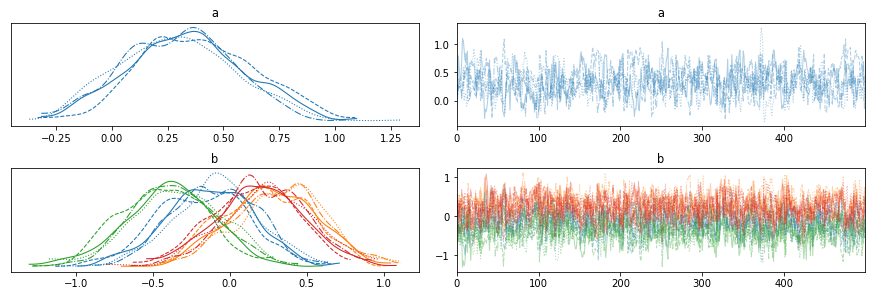

In [15]:
with pm.Model() as m_11_4_no_inter:
    a = pm.Normal("a", mu = 0, sigma = 1.5, shape = 1)
    b  = pm.Normal("b", mu = 0, sigma = 0.5, shape = 4)
    logitp = a + b[chimps.treat_ind]
    sigmoid = pm.Deterministic("sigmoid", pm.math.invlogit(logitp))
    y = pm.Bernoulli("y",sigmoid, observed=chimps.pulled_left )
    
    #get the quadratic approximation info
    approx_mean = pm.find_MAP()
    Hess = pm.find_hessian(approx_mean, vars=[a,b])
    
    #run MCMC
    sample_no_inter = pm.sample(draws= 500, chains = 4)
    pm.traceplot(sample_no_inter, ["a","b"])

In [22]:
#model comparison dictionary
model_compare = az.compare( {"no_inter" : sample_no_inter, "inter" : m_11_4_sample },

                           scale="deviance"
)

/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [23]:
model_compare

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
inter,0,531.686,8.22395,0,1,9.07836,0,False,deviance
no_inter,1,682.465,3.63611,150.779,3.9966e-23,18.3529,18.3804,False,deviance


The model with the actor specific intercept terms by far out performs the model without it. This is not surprising given the analysis in the book. This showed that the actor variable held most of the explanatory power of the model.

11H2. The data contained in library(MASS);data(eagles) are records of salmon pirating attempts by Bald Eagles in Washington State. See ?eagles for details. While one eagle feeds, sometimes another will swoop in and try to steal the salmon from it. Call the feeding eagle the “victim” and
the thief the “pirate.” Use the available data to build a binomial GLM of successful pirating attempts.

(a) Consider the following model:

yi ∼ Binomial(ni
, pi)

$logit(pi) = α + β_P P_i + β_V V_i + β_A A_i$

α ∼ Normal(0, 1.5)

$β_P, β_V, β_A$ ∼ Normal(0, 0.5)

where y is the number of successful attempts, n is the total number of attempts, P is a dummy variable
indicating whether or not the pirate had large body size, V is a dummy variable indicating whether
or not the victim had large body size, and finally A is a dummy variable indicating whether or not
11.5. PRACTICE 367
the pirate was an adult. Fit the model above to the eagles data, using both quap and ulam. Is the
quadratic approximation okay?



Answer: You can obtain this data from the R library called MASS as the instructions state. Google around to figure out how to do this if you're unfamiliar with R.

The information from ?eagles is as follows:

The ‘eagles’ data frame has 8 rows and 5 columns.                                                                                                                                                               ‘y’ Number of successful attempts.                                                                                                                                                                              ‘n’ Total number of attempts.                                                                                                                                                                                   ‘P’ Size of pirating eagle (‘L’ = large, ‘S’ = small).                                                                                                                                                          ‘A’ Age of pirating eagle (‘I’ = immature, ‘A’ = adult).                                                                                                                                                        ‘V’ Size of victim eagle (‘L’ = large, ‘S’ = small). 

We'll need this to help interpret the results of the model.

In [3]:
eagles = pd.read_csv("./data/eagles.csv")

In [4]:
eagles["P"].astype("category").cat.codes

0    0
1    0
2    0
3    0
4    1
5    1
6    1
7    1
dtype: int8

In [5]:
#add indexes which match our intuition
eagles["P_ind"] = -(eagles["P"].astype("category").cat.codes - 1)
eagles["V_ind"] = -(eagles["V"].astype("category").cat.codes - 1)
eagles["A_ind"] = -(eagles["A"].astype("category").cat.codes - 1)

In [6]:
eagles

,Unnamed: 0,y,n,P,A,V,P_ind,V_ind,A_ind
0,1,17,24,L,A,L,1,1,1
1,2,29,29,L,A,S,1,0,1
2,3,17,27,L,I,L,1,1,0
3,4,20,20,L,I,S,1,0,0
4,5,1,12,S,A,L,0,1,1
5,6,15,16,S,A,S,0,0,1
6,7,0,28,S,I,L,0,1,0
7,8,1,4,S,I,S,0,0,0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 3 seconds.


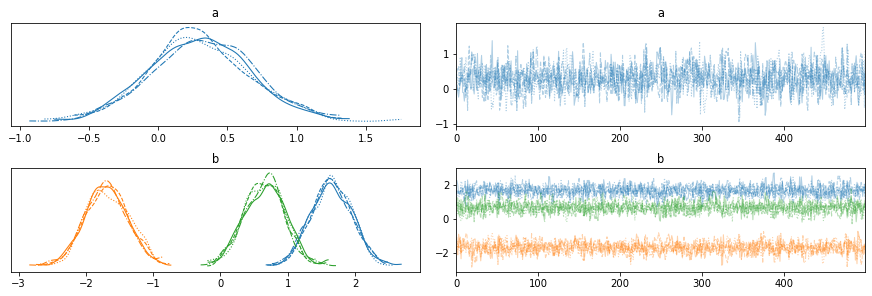

In [24]:
with pm.Model() as H11_2_a:
    a = pm.Normal("a", mu = 0, sigma = 1.5, shape = 1)
    b  = pm.Normal("b", mu = 0, sigma = 0.5, shape =3)
    
    logitp = a + eagles.P_ind.values*b[0] + eagles.V_ind.values*b[1] + eagles.A_ind.values*b[2]
    p_success = pm.Deterministic("p_success", pm.math.invlogit(logitp))
    y = pm.Binomial("y",n = eagles.n, p=p_success, observed=eagles.y )
    
    #get the quadratic approximation info
    approx_mean = pm.find_MAP()
    Hess = pm.find_hessian(approx_mean, vars=[a,b])
    
    #run MCMC
    no_interaction_sample = pm.sample(draws= 500, chains = 4)
    pm.traceplot(no_interaction_sample, ["a","b"])

In [25]:
var_cov = np.linalg.inv(Hess)#the variance covariance matrix
MCMC_interval = pm.summary(no_interaction_sample,var_names=["a","b"], hdi_prob=0.95)[["hdi_2.5%", "hdi_97.5%"]]#these are bounds
QUAP_interval = np.sqrt(np.diagonal(var_cov)) #these are standard deviations

/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


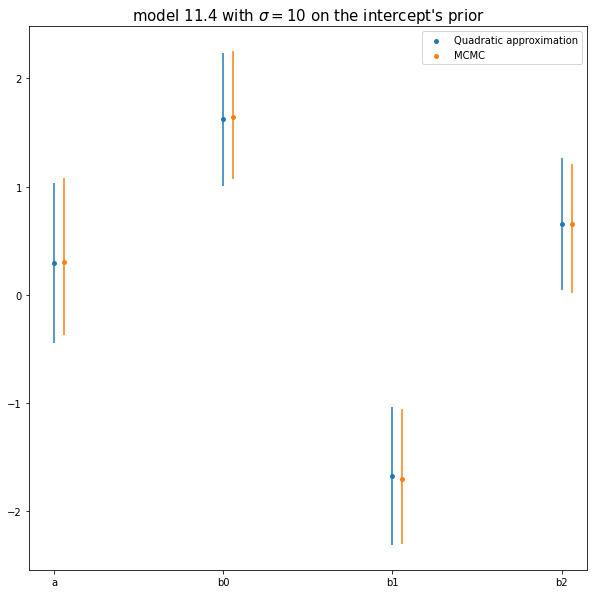

In [28]:
fig, ax = plt.subplots(figsize=(10,10))

x = ["a"] + [ "b" + str(i) for i in range(3)]

#plot the QUAP
y = np.append(approx_mean["a"],approx_mean["b"])
ax.scatter(x , y, s = 15 , label="Quadratic approximation" )
#add +/- 2 std error bars to the quap
ax.errorbar(x, y, QUAP_interval*2 ,fmt=" ")

#create an offset for visual appeal and plot the MCMC approximation of the posterior
tr = mtrans.offset_copy(ax.transData, fig=fig, x=10, y=0, units='points')
y = np.append(no_interaction_sample["a"].mean(axis=0),no_interaction_sample["b"].mean(axis=0))
ax.scatter(x ,y , s = 15, label="MCMC",transform=tr)
#error array
error = np.append((y - MCMC_interval.values[:,0].T ),( MCMC_interval.values[:,1].T - y)).reshape(2,-1)
ax.errorbar(x,y, yerr = error, transform=tr,fmt=" ")

plt.title("model 11.4 with $\sigma = 10$ on the intercept's prior", size = 15)
plt.legend()
plt.show()

The quadratic approximation yeilds similar results to MCMC for this model.

(b) Now interpret the estimates. If the quadratic approximation turned out okay, then it’s okay
to use the quap estimates. Otherwise stick to ulam estimates. Then plot the posterior predictions.
Compute and display both (1) the predicted probability of success and its 89% interval for each row (i)
in the data, as well as (2) the predicted success count and its 89% interval. What different information
does each type of posterior prediction provide?

Let's interpret the $\beta$ terms in the model. It can be seen that if the $P_i = 1$, that is, if the pirate bird is large, this makes the likelihood of successful pirating increase, as seen by the $b_0$ term in the figure above. In contrast, if $V_i = 1$, the victim is large, this has a negative effect on the model, decreasing the likelihood of successful pirating. Both of these make intuitive sense. Big birds are more able to get what they want. The last term of the model $\beta_A$ is the effect of impact that the pirating birds maturity. The $\beta_A$ term is only present if the bird is an adult, and this has a positive impact of the pirates chance of success (denoted by $b_2$ above), though it is not as predictive as the bird's size.

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

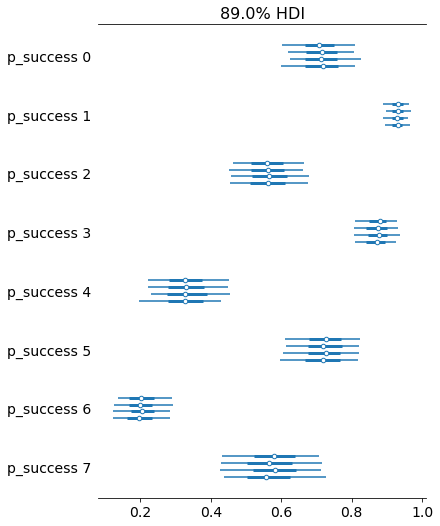

In [285]:
pm.forestplot(no_interaction_sample, var_names="p_success",hdi_prob=0.89,)

Here I am sampling the posterior predictions from our posterior distribution to produce the prediction intervals. However, this step in going from the posterior parameter samples to the posterior outcome samples could and probably should be done analytically.

In [286]:
post_samples = np.random.binomial(n = (eagles.n.values.T), p =no_interaction_sample["p_success"]  )
post_pred_intervals = pm.hpd(post_samples,hdi_prob=0.89)
post_pred_means = post_samples.mean(axis = 0)
post_pred_bounds = np.append((post_pred_means - post_pred_intervals[:,0].T),post_pred_intervals[:,1].T-post_pred_means).reshape((2,-1))

/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


Text(0.5, 1.0, 'Posterior prediction on the number of successes')

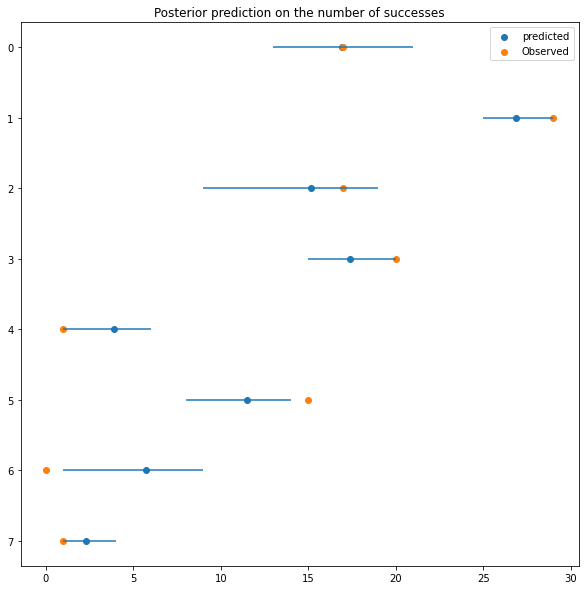

In [287]:
fig, ax = plt.subplots(figsize=(10,10))
y = [ str(i) for i in range(7,-1,-1)]
#plot the posterior predictions
ax.scatter( np.flip(post_pred_means), (y), label="predicted" )
ax.errorbar(np.flip(post_pred_means),y, xerr = np.flip(post_pred_bounds,axis=1), fmt=" ")

#plot the real data with an offset
ax.scatter(np.flip(eagles.y), y, label="Observed")

plt.legend()

plt.title("Posterior prediction on the number of successes")

If you happen to have seen the results for the question in the first edition you'll notice a discrepancy. (See here https://github.com/pymc-devs/resources/blob/master/Rethinking/end-of-chapter-practice-problems/ch-10.ipynb). The author of that solution used a 5 for the std deviation on the priors, which is not what is asked for in the question (at least not what's asked for in the version of the question in the 2nd edition). These are bad priors, and their model grossly overfits to the data, which is why their posterior predictions of the in sample data are so accurate. However this is just over fit due to the lack of regularizing priors.

The first of the two plots above gives us the posterior on parameter values in the model. The second plot gives us an indidcation of what the model actually expects of the data.


(c) Now try to improve the model. Consider an interaction between the pirate’s size and age
(immature or adult). Compare this model to the previous one, using WAIC. Interpret.

Answer: We create a new index based on both the pirates size and maturity. Using this index we can then model the interaction between these variables.

In [7]:
p_a_df = eagles[["P","A"]].drop_duplicates().reset_index()
p_a_df["interaction_index"] = p_a_df.index
eagles = pd.merge(eagles,p_a_df, "outer",on=["P","A"])

In [8]:
eagles

,Unnamed: 0,y,n,P,A,V,P_ind,V_ind,A_ind,index,interaction_index
0,1,17,24,L,A,L,1,1,1,0,0
1,2,29,29,L,A,S,1,0,1,0,0
2,3,17,27,L,I,L,1,1,0,2,1
3,4,20,20,L,I,S,1,0,0,2,1
4,5,1,12,S,A,L,0,1,1,4,2
5,6,15,16,S,A,S,0,0,1,4,2
6,7,0,28,S,I,L,0,1,0,6,3
7,8,1,4,S,I,S,0,0,0,6,3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_inter, bv, a]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 3 seconds.
The acceptance probability does not match the target. It is 0.8803936686782106, but should be close to 0.8. Try to increase the number of tuning steps.


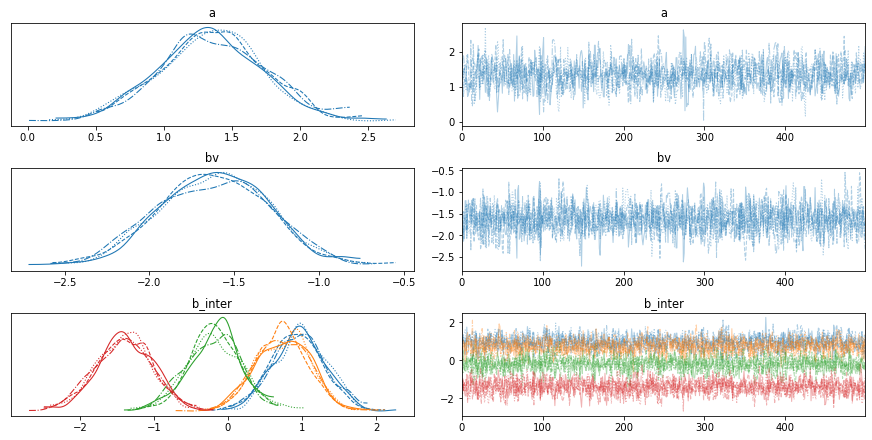

In [9]:
with pm.Model() as H11_2_a_inter:
    a = pm.Normal("a", mu = 0, sigma = 1.5, shape = 1)
    bv  = pm.Normal("bv", mu = 0, sigma = 0.5, shape =1)
    b_inter = pm.Normal("b_inter", mu = 0, sigma = 0.5, shape =4)
    
    logitp = a +  b_inter[eagles.interaction_index.values] + eagles.V_ind.values*bv
    p_success = pm.Deterministic("p_success", pm.math.invlogit(logitp))
    y = pm.Binomial("y",n = eagles.n, p=p_success, observed=eagles.y )
    
    #get the quadratic approximation info
    approx_mean = pm.find_MAP()
    Hess = pm.find_hessian(approx_mean, vars=[a,bv,b_inter])
    
    #run MCMC
    interaction_sample = pm.sample(draws= 500, chains = 4)
    pm.traceplot(interaction_sample, ["a","bv","b_inter"])

/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

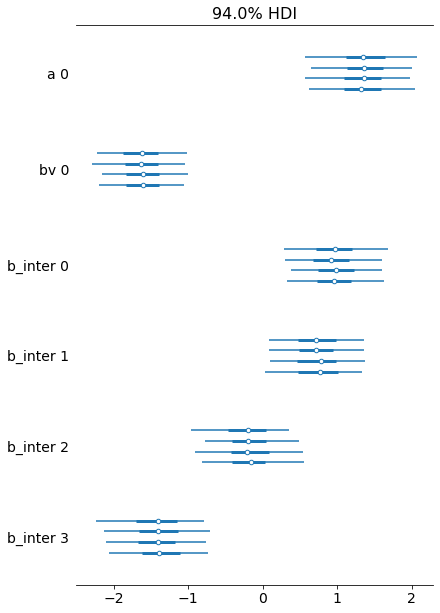

In [10]:
pm.forestplot(interaction_sample, var_names=["a","bv","b_inter"])

In [19]:
1/(1+np.exp(-1))

0.7310585786300049

To remind ourselves of what these b_inter terms correspond to, lets display the key table again (see the cell below). It can be seen that as we go down the list, the set of interactions start to predict the pirates will become less and less successful. This makes intuitive sense. If we look at the large, adult pirate, this corresponds to b_inter_0, which has a value around one. One the outcome scale this corresponds to sigmoid(b_inter_o) ≃ sigmoid(1) = 0.73. That is, with ignoring the other input variables into the logit link, knowing that a pirate bird is both large and adolescent would be enough to bet on the pirate bird winning the duel. 

In contrast to this, the small and immature bird, denoted by b_3_inter is enough for us to believe this bird is unlikely to be a successful pirate. On the outcome scale sigmoid(-1.5) ≃ 0.18

In [20]:
p_a_df[["P","A","interaction_index"]]

,P,A,interaction_index
0,L,A,0
1,L,I,1
2,S,A,2
3,S,I,3


In [21]:
post_samples = np.random.binomial(n = (eagles.n.values.T), p =interaction_sample["p_success"]  )
post_pred_intervals = pm.hpd(post_samples,hdi_prob=0.89)
post_pred_means = post_samples.mean(axis = 0)
post_pred_bounds = np.append((post_pred_means - post_pred_intervals[:,0].T),post_pred_intervals[:,1].T-post_pred_means).reshape((2,-1))

/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


Text(0.5, 1.0, 'Posterior prediction on the number of successes')

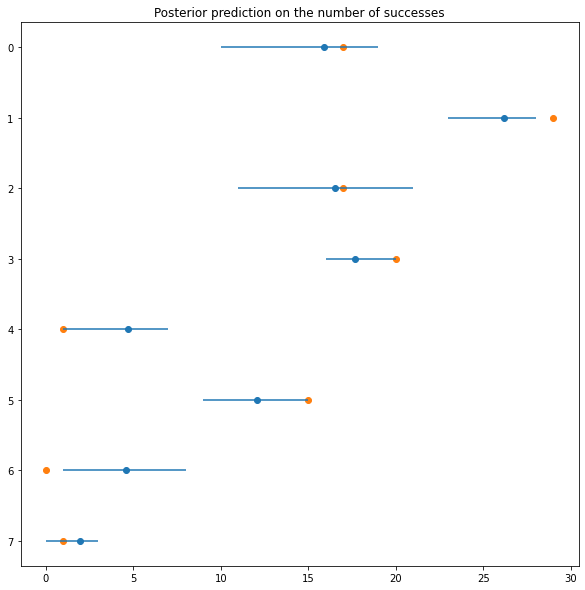

In [22]:
fig, ax = plt.subplots(figsize=(10,10))
y = [ str(i) for i in range(7,-1,-1)]
#plot the posterior predictions
ax.scatter( np.flip(post_pred_means), (y) )
ax.errorbar(np.flip(post_pred_means),y, xerr = np.flip(post_pred_bounds,axis=1), fmt=" ")

#plot the real data with an offset
ax.scatter(np.flip(eagles.y), y)


plt.title("Posterior prediction on the number of successes")

In [34]:
#perform model comparison
model_compare = az.compare({"No_interaction":no_interaction_sample,"Interaction": interaction_sample }, scale = "deviance")

/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:682: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future rele

<AxesSubplot:xlabel='Deviance'>

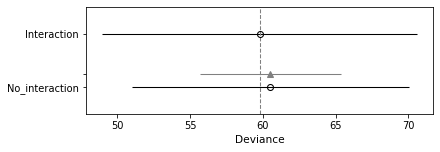

In [36]:
az.plot_compare(model_compare, insample_dev=False)

Neither model really outshines the other here, perhaps indicating that the interaction is a mirage. That is, these maturity and the size are rather independent phenomena. 

11H3. The data contained in data(salamanders) are counts of salamanders (Plethodon elongatus)
from 47 different 49-m2 plots in northern California.181 The column SALAMAN is the count in each
plot, and the columns PCTCOVER and FORESTAGE are percent of ground cover and age of trees in the
plot, respectively. You will model SALAMAN as a Poisson variable.

(a) Model the relationship between density and percent cover, using a log-link (same as the example in the book and lecture). Use weakly informative priors of your choosing. Check the quadratic
approximation again, by comparing quap to ulam. Then plot the expected counts and their 89% interval against percent cover. In which ways does the model do a good job? A bad job?

(b) Can you improve the model by using the other predictor, FORESTAGE? Try any models you
think useful. Can you explain why FORESTAGE helps or does not help with prediction?

In [37]:
#load the data
salamander = pd.read_csv("./data/salamanders.csv",delimiter=";")

In [39]:
#inspect the data
salamander.head()

,SITE,SALAMAN,PCTCOVER,FORESTAGE
0,1,13,85,316
1,2,11,86,88
2,3,11,90,548
3,4,9,88,64
4,5,8,89,43


Let's standardise the variables PCTCOVER and FORESTAGE to the relative scale so that they're only on the relative scale of 0 to max is 0 to 1. This will help aid the interpretation as both of these parameters naturally have a zero on them.

In [77]:
salamander["s_cover"] = salamander["PCTCOVER"]/salamander["PCTCOVER"].max()
salamander["s_f_age"] = salamander["FORESTAGE"]/salamander["FORESTAGE"].max()

We'll use use mu = 1 and sigma = 1 for the priors on a and b of the model. Plotting this prior on the outcome scale is indicative of what the priors expect. There's one really vague outlier out there near 100, but this is exceptionally rare. If you alter the model to have sigma near 2, it's radically different.

In [100]:
#define the model for testing priors

with pm.Model() as trial_prior:
    a = pm.Normal("a", mu = 1, sigma = 1, shape = 1) 
    loglam = a + b * salamander["s_cover"]
    lam = pm.Deterministic("sigmoid", pm.math.exp(loglam))
    y = pm.Poisson("y",lam, observed=salamander["SALAMAN"].values )
    prior_checks = pm.sample_prior_predictive(samples=1000, var_names=["a"],random_seed=42)
    

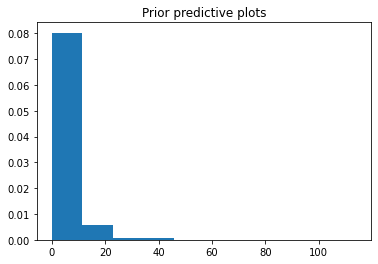

In [101]:
plt.hist(np.random.poisson(lam = np.exp(prior_checks["a"])), density = True)
plt.title("Prior predictive plots")

plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.889351595910699, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


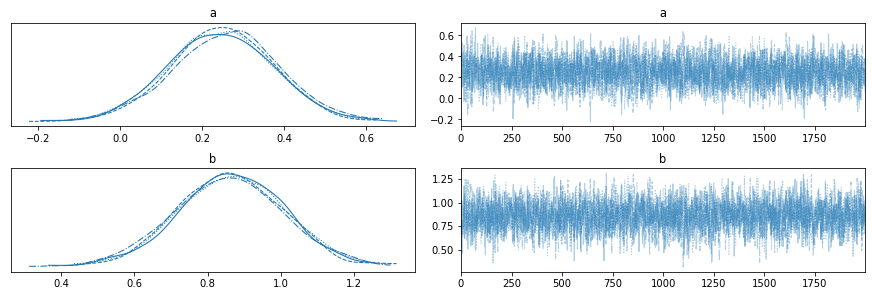

In [109]:
with pm.Model() as H_11_3:
    a = pm.Normal("a", mu = 1, sigma = 1, shape = 1) 
    b  = pm.Normal("b", mu = 1, sigma = 1, shape = 1)
    loglam = a + b * salamander["s_cover"]
    lam = pm.Deterministic("lam", pm.math.exp(loglam))
    y = pm.Poisson("y",lam, observed=salamander["SALAMAN"].values )
    #for the quap
    approx_mean = pm.find_MAP()
    Hess = pm.find_hessian(approx_mean, vars=[a,b])
    
    #run MCMC
    H_11_3_sample = pm.sample(draws= 2000, chains = 4)
    pm.traceplot(H_11_3_sample, ["a","b"])

/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


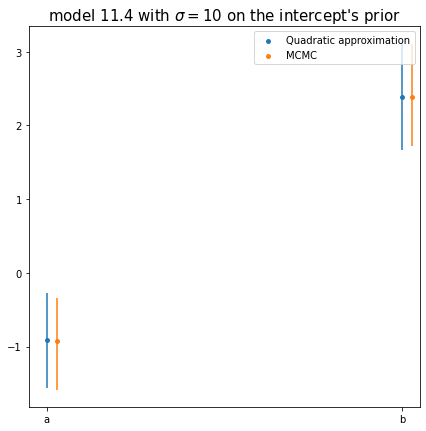

In [106]:
var_cov = np.linalg.inv(Hess)#the variance covariance matrix
MCMC_interval = pm.summary(H_11_3_sample,var_names=["a","b"], hdi_prob=0.95)[["hdi_2.5%", "hdi_97.5%"]]#these are bounds
QUAP_interval = np.sqrt(np.diagonal(var_cov)) #these are standard deviations

fig, ax = plt.subplots(figsize=(7,7))

x = ["a","b"]

#plot the QUAP
y = np.append(approx_mean["a"],approx_mean["b"])
ax.scatter(x , y, s = 15 , label="Quadratic approximation" )
#add +/- 2 std error bars to the quap
ax.errorbar(x, y, QUAP_interval*2 ,fmt=" ")

#create an offset for visual appeal and plot the MCMC approximation of the posterior
tr = mtrans.offset_copy(ax.transData, fig=fig, x=10, y=0, units='points')
y = np.append(H_11_3_sample["a"].mean(axis=0),H_11_3_sample["b"].mean(axis=0))
ax.scatter(x ,y , s = 15, label="MCMC",transform=tr)
#error array
error = np.append((y - MCMC_interval.values[:,0].T ),( MCMC_interval.values[:,1].T - y)).reshape(2,-1)
ax.errorbar(x,y, yerr = error, transform=tr,fmt=" ")

plt.title("model 11.4 with $\sigma = 10$ on the intercept's prior", size = 15)
plt.legend()
plt.show()

In [129]:
x = np.linspace(0,1,100)
y = np.exp(H_11_3_sample["a"] + np.outer(H_11_3_sample["b"],x))

In [138]:
post_inter = pm.hpd(y_post_pred, hdi_prob=0.89)

/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


In [139]:
#sample the posterior
y_post_pred = np.random.poisson(lam=y)

In [140]:
post_inter = pm.hpd(y_post_pred, hdi_prob=0.89)

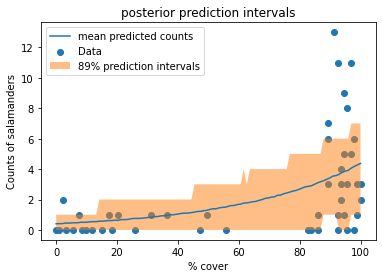

In [148]:
plt.plot(x*100, y_post_pred.mean(axis=0), label="mean predicted counts")
plt.scatter(salamander["s_cover"]*100,salamander["SALAMAN"], label="Data")
plt.fill_between(x*100, post_inter[:,0], post_inter[:,1], alpha = 0.5, label="89% prediction intervals")

plt.title("posterior prediction intervals")
plt.legend()
plt.xlabel("% cover")
plt.ylabel("Counts of salamanders")

plt.show()

This model leaves a lot to be desired at the higher end as there's a lot more dispersion in the data than it expects. It would be surprising if % cover was able to account for everything in the data.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.
The acceptance probability does not match the target. It is 0.886539063400988, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8813537115520896, but should be close to 0.8. Try to increase the number of tuning steps.


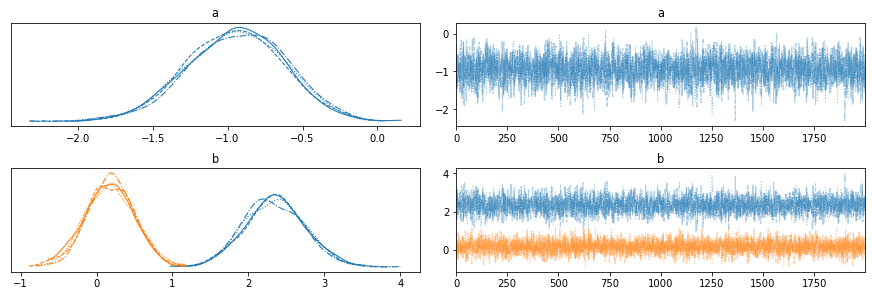

In [151]:
with pm.Model() as H_11_3_b:
    a = pm.Normal("a", mu = 1, sigma = 1, shape = 1) 
    b  = pm.Normal("b", mu = 1, sigma = 1, shape = 2)
    loglam = a + b[0] * salamander["s_cover"].values + b[1] * salamander["s_f_age"].values
    lam = pm.Deterministic("lam", pm.math.exp(loglam))
    y = pm.Poisson("y",lam, observed=salamander["SALAMAN"].values )
    #for the quap
    approx_mean = pm.find_MAP()
    Hess = pm.find_hessian(approx_mean, vars=[a,b])
    
    #run MCMC
    H_11_3_b_sample = pm.sample(draws= 2000, chains = 4)
    pm.traceplot(H_11_3_b_sample, ["a","b"])

In [153]:
az.compare( {"with FORESTAGE":H_11_3_b_sample,"without FORESTAGE":H_11_3_sample}, scale="deviance" )

/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
without FORESTAGE,0,214.04,4.13494,0,0.854261,26.0543,0,False,deviance
with FORESTAGE,1,218.261,6.85861,4.2211,0.145739,25.3396,2.20864,False,deviance


The model with FOREST age included doesn't perform as well. I can't think of any reason that this would be a useful variable, or why this would have a strong causal impact on the salamander density except through a very long winding DAG. I light of the WAIC, it appears to be adding a meaningless parameter to the model and not giving much in return for this which is why it's penalised.

11H4. The data in data(NWOGrants) are outcomes for scientific funding applications for the Netherlands Organization for Scientific Research (NWO) from 2010–2012 (see van der Lee and Ellemers
(2015) for data and context). These data have a very similar structure to the UCBAdmit data discussed
in the chapter. I want you to consider a similar question: What are the total and indirect causal effects of gender on grant awards? Consider a mediation path (a pipe) through discipline. Draw the
corresponding DAG and then use one or more binomial GLMs to answer the question. What is your
causal interpretation? If NWO’s goal is to equalize rates of funding between men and women, what
type of intervention would be most effective?

Answer: This requires a bit of nuance and thought. To begin with, let's run the DAG hinted at in the chapter in the book. 

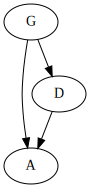

In [159]:
from causalgraphicalmodels import CausalGraphicalModel

Dag = CausalGraphicalModel(
    nodes=["D","A","G"], # Amusingly it spells DAG
    edges=[
        ("G","D"),
        ("G", "A"),
        ("D","A")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
Dag.draw()

Let's use a model like that in the chapter. That model has no interaction between gender and department, which is obviously absurd, but is a reasonable starting point for us to start answering the question that we're asking. To find the direct affect, we must regress age against Gender and discipline in the same model, and then "hold the discipline constant". 

We can measure the total effect of gender on application success by simply using that as the only predictor variable. As $Total = Indirect + Direct$, we can rearrange to get $Indirect = Total - Direct$. This will allow us to infer whether it's the direct or indirect effect which matters the most causing gender differences.

In [160]:
Grants = pd.read_csv("./data/NWOGrants.csv",delimiter=";")

In [330]:
Grants.head()

,discipline,gender,applications,awards,discipline_idx,gender_idx
0,Chemical sciences,m,83,22,0,1
1,Chemical sciences,f,39,10,0,0
2,Physical sciences,m,135,26,5,1
3,Physical sciences,f,39,9,5,0
4,Physics,m,67,18,6,1


In [331]:
Grants["discipline_idx"] = Grants.discipline.astype("category").cat.codes
Grants["gender_idx"] = Grants.gender.astype("category").cat.codes

In [332]:
Grants.discipline_idx.drop_duplicates().shape # number of departments

(9,)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.


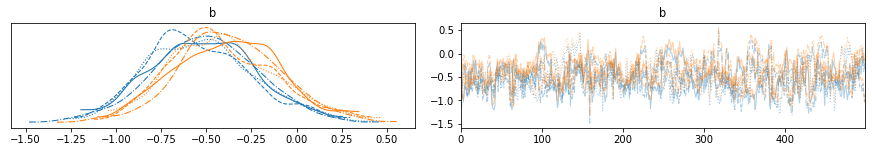

In [335]:
#model with both Gender to predict Awards

with pm.Model() as H11_4_G_A:
    b  = pm.Normal("b", mu = 0, sigma = 1.5, shape =2) # gender predictor
    
    logitp = b[Grants.gender_idx]
    p_success = pm.Deterministic("p_success", pm.math.invlogit(logitp))
    y = pm.Binomial("y",n = Grants.applications, p=p_success, observed=Grants.awards )
    
    #get the quadratic approximation info
    approx_mean = pm.find_MAP()
    Hess = pm.find_hessian(approx_mean, vars=[b])
    
    #run MCMC
    H11_4_G_A_sample = pm.sample(draws= 500, chains = 4)
    pm.traceplot(H11_4_sample, ["b"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 5 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


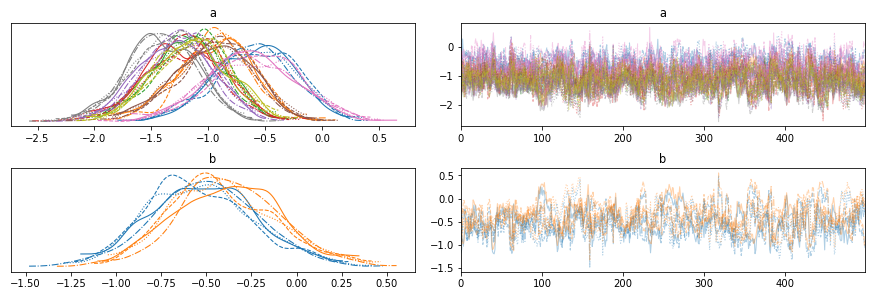

In [336]:
#model with both Gender and Discpline included

with pm.Model() as H11_4_GD_A:
    a = pm.Normal("a", mu = 0, sigma = 1.5, shape = 9) # discipline predictor
    b  = pm.Normal("b", mu = 0, sigma = 1.5, shape =2) # gender predictor
    
    logitp = a[Grants.discipline_idx] + b[Grants.gender_idx]
    p_success = pm.Deterministic("p_success", pm.math.invlogit(logitp))
    y = pm.Binomial("y",n = Grants.applications, p=p_success, observed=Grants.awards )
    
    #get the quadratic approximation info
    approx_mean = pm.find_MAP()
    Hess = pm.find_hessian(approx_mean, vars=[a,b])
    
    #run MCMC
    H11_4_GD_A_sample = pm.sample(draws= 500, chains = 4)
    pm.traceplot(H11_4_sample, ["a","b"])

In [337]:
#import inv_logt python equivalent
from scipy.special import expit

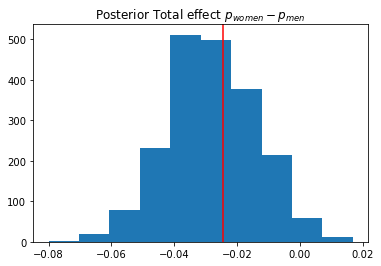

In [345]:
p_diff_G_A = expit(H11_4_G_A_sample["b"][:,0]) - expit(H11_4_G_A_sample["b"][:,1])

plt.hist(p_diff_G_A)
plt.title("Posterior Total effect $p_{women} - p_{men}$")
plt.axvline(p_diff.mean(), c = "r")
plt.show()

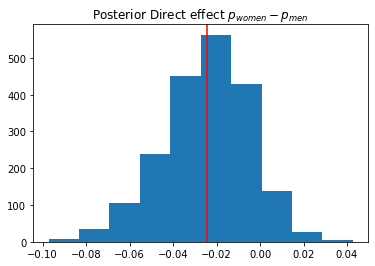

In [360]:
p_diff_GD_A = expit(H11_4_GD_A_sample["b"][:,0]) - expit(H11_4_GD_A_sample["b"][:,1])

plt.hist(p_diff_GD_A)
plt.title("Posterior Direct effect $p_{women} - p_{men}$")
plt.axvline(p_diff_GD_A.mean(), c = "r")
plt.show()

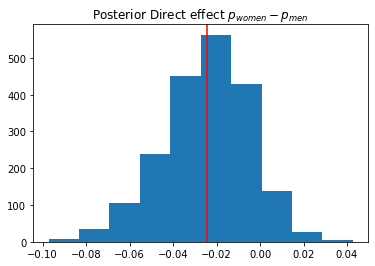

In [361]:
plt.hist(p_diff_GD_A)
plt.title("Posterior Direct effect $p_{women} - p_{men}$")
plt.axvline(p_diff.mean(), c = "r")
plt.show()

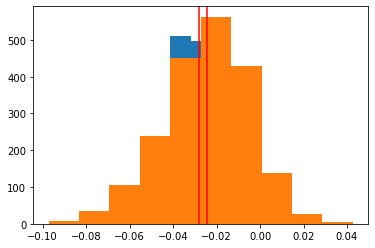

In [364]:
plt.hist(p_diff_G_A)
#plt.title("Posterior Total effect $p_{women} - p_{men}$")
plt.axvline(p_diff_G_A.mean(), c = "r")
plt.hist( p_diff_GD_A)
plt.axvline(p_diff_GD_A.mean(), c = "r")

plt.title("The difference between the total and direct effect is minimal")
plt.show()

In [358]:
pm.summary(H11_4_G_A_sample, var_names="b")

/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b[0],-1.739,0.082,-1.910,-1.602,0.002,0.001,1894.0,1877.0,1911.0,1467.0,1.0
b[1],-1.532,0.063,-1.653,-1.423,0.001,0.001,1952.0,1941.0,1958.0,1521.0,1.0


In [356]:
pm.summary(H11_4_GD_A_sample, var_names="b")

/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b[0],-1.262,0.487,-2.251,-0.388,0.035,0.025,188.0,188.0,190.0,124.0,1.02
b[1],-1.122,0.486,-2.151,-0.276,0.036,0.025,186.0,186.0,188.0,165.0,1.02


It can be seen that the direct effect appears to be responsible for almost all of the difference. Thus, not much of the difference is explained throught the indirect effect of department.

# This needs a better explanation, rewrite and understanding more generally

11H5. Suppose that the NWO Grants sample has an unobserved confound that influences both
choice of discipline and the probability of an award. One example of such a confound could be the
career stage of each applicant. Suppose that in some disciplines, junior scholars apply for most of the
grants. In other disciplines, scholars from all career stages compete. As a result, career stage influences
discipline as well as the probability of being awarded a grant. Add these influences to your DAG from
the previous problem. What happens now when you condition on discipline? Does it provide an
un-confounded estimate of the direct path from gender to an award? Why or why not? Justify your
answer with the backdoor criterion. If you have trouble thinking this though, try simulating fake
data, assuming your DAG is true. Then analyze it using the model from the previous problem. What
do you conclude? Is it possible for gender to have a real direct causal influence but for a regression
conditioning on both gender and discipline to suggest zero influence?

Answer: We now add C, for Career stage to our DAG.

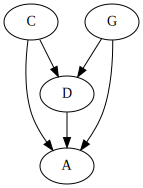

In [352]:
from causalgraphicalmodels import CausalGraphicalModel

Dag = CausalGraphicalModel(
    nodes=["D","A","G","C"], # Amusingly it spells DAG
    edges=[
        ("G","D"),
        ("G", "A"),
        ("D","A"),
        ("C","D"),
        ("C","A")
        
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
Dag.draw()

D is now a collider of both G and C. Therefore conditioning on D bias inference about the impact of G on A. That is, conditioning on D opens up a back door from G to A.

If you were to condition on D, this could induce a spurious relationship between C and G which could mask the direct effect of G on A.

11H6. The data in data(Primates301) are 301 primate species and associated measures. In this
problem, you will consider how brain size is associated with social learning. There are three parts.

(a) Model the number of observations of social_learning for each species as a function of the
log brain size. Use a Poisson distribution for the social_learning outcome variable. Interpret the
resulting posterior. (b) Some species are studied much more than others. So the number of reported
instances of social_learning could be a product of research effort. Use the research_effort
variable, specifically its logarithm, as an additional predictor variable. Interpret the coefficient for log
research_effort. How does this model differ from the previous one? (c) Draw a DAG to represent
how you think the variables social_learning, brain, and research_effort interact. Justify the
DAG with the measured associations in the two models above (and any other models you used).

In [370]:
Primates = pd.read_csv("./data/Primates301.csv", delimiter=";")

In [391]:
Primates.research_effort.max()

755.0

In [417]:
Primates

,name,genus,species,subspecies,spp_id,genus_id,social_learning,research_effort,brain,body,group_size,gestation,weaning,longevity,sex_maturity,maternal_investment
0,Allenopithecus_nigroviridis,Allenopithecus,nigroviridis,NaN,1,1,0.0,6.0,58.02,4655.00,40.00,NaN,106.15,276.0,NaN,NaN
1,Allocebus_trichotis,Allocebus,trichotis,NaN,2,2,0.0,6.0,NaN,78.09,1.00,NaN,NaN,NaN,NaN,NaN
2,Alouatta_belzebul,Alouatta,belzebul,NaN,3,3,0.0,15.0,52.84,6395.00,7.40,NaN,NaN,NaN,NaN,NaN
3,Alouatta_caraya,Alouatta,caraya,NaN,4,3,0.0,45.0,52.63,5383.00,8.90,185.92,323.16,243.6,1276.72,509.08
4,Alouatta_guariba,Alouatta,guariba,NaN,5,3,0.0,37.0,51.70,5175.00,7.40,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,Trachypithecus_pileatus,Trachypithecus,pileatus,NaN,297,67,0.0,5.0,103.64,11794.00,8.50,NaN,NaN,NaN,NaN,NaN
297,Trachypithecus_poliocephalus,Trachypithecus,poliocephalus,NaN,298,67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
298,Trachypithecus_vetulus,Trachypithecus,vetulus,NaN,299,67,0.0,2.0,61.29,6237.00,8.35,204.72,245.78,276.0,1113.70,450.50
299,Varecia_rubra,Varecia,rubra,NaN,300,68,NaN,NaN,31.08,3470.00,NaN,NaN,NaN,NaN,NaN,NaN


In [445]:
Data_a = Primates[["social_learning","brain","research_effort"]].dropna()

In [446]:
Data_a["log_brain"] = np.log(Data_a["brain"])
Data_a["log_research"] = np.log(Data_a["research_effort"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.8989295061481786, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8812578975209615, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


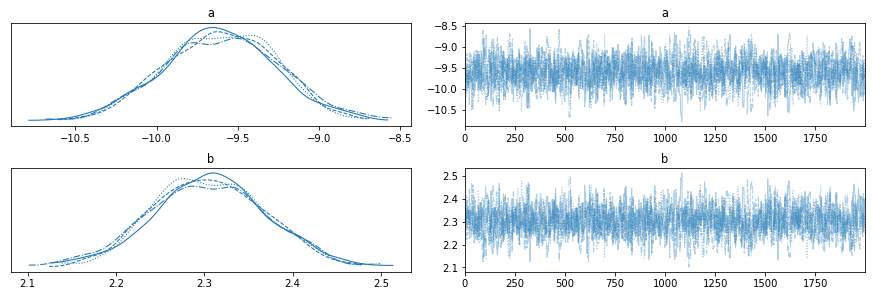

In [450]:
#define the model

with pm.Model() as H_11_6a:
    a = pm.Normal("a", mu = 0, sigma = 3, shape = 1)
    b  = pm.Normal("b", mu = 0, sigma = 3, shape = 1)
    loglam = a + b*Data_a["log_brain"]
    lam = pm.Deterministic("sigmoid", pm.math.exp(loglam))
    y = pm.Poisson("y",lam, observed=Data_a["social_learning"])
    #priors = pm.sample_prior_predictive(samples = 2000,var_names=["a","b"])
    
    #get the quadratic approximation info
    approx_mean = pm.find_MAP()
    Hess = pm.find_hessian(approx_mean, vars=[a,b])
    
    #run MCMC
    H_11_6a_sample = pm.sample(draws= 2000, chains = 4,start=approx_mean)
    pm.traceplot(H_11_6a_sample, ["a","b"])

In [451]:
pm.summary(H_11_6a_sample, var_names=["a","b"])

/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-9.611,0.347,-10.261,-8.973,0.010,0.007,1225.0,1225.0,1218.0,1380.0,1.0
b[0],2.305,0.064,2.187,2.423,0.002,0.001,1232.0,1232.0,1226.0,1400.0,1.0


/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


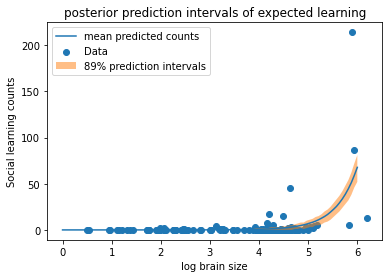

In [449]:
x = np.linspace(0,6,100)
y = np.exp(H_11_6a_sample["a"] + np.outer(H_11_6a_sample["b"],x))


#sample the posterior
y_post_pred = np.random.poisson(lam=y)
post_inter = pm.hpd(y_post_pred, hdi_prob=0.89)

plt.plot(x, y_post_pred.mean(axis=0), label="mean predicted counts")
plt.scatter(Data_a["log_brain"],Data_a["social_learning"], label="Data")
plt.fill_between(x, post_inter[:,0], post_inter[:,1], alpha = 0.5, label="89% prediction intervals")

plt.title("posterior prediction intervals of expected learning")
plt.legend()
plt.xlabel("log brain size")
plt.ylabel("Social learning counts")

plt.show()

This model is heavily weight down by data at the lower end of the spectrum, and the rare examples at the higher end are difficult for the model to predict. It can still be seen that the model expects that larger brains are associated with social learning.

INFO (theano.gof.compilelock): Refreshing lock /home/aidan/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.10-x86_64-3.8.5-64/lock_dir/lock


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
The acceptance probability does not match the target. It is 0.8846320873514637, but should be close to 0.8. Try to increase the number of tuning steps.


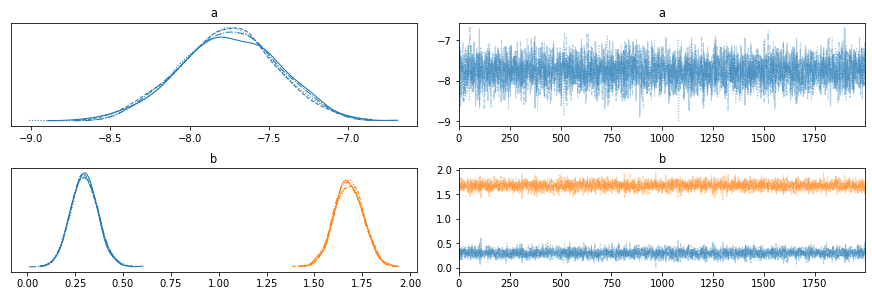

In [452]:
with pm.Model() as H_11_6b:
    a = pm.Normal("a", mu = 0, sigma = 3, shape = 1)
    b  = pm.Normal("b", mu = 0, sigma = 3, shape = 2)
    loglam = a + b[0]*Data_a["log_brain"] + b[1]*Data_a["log_research"]
    lam = pm.Deterministic("sigmoid", pm.math.exp(loglam))
    y = pm.Poisson("y",lam, observed=Data_a["social_learning"])
    #priors = pm.sample_prior_predictive(samples = 2000,var_names=["a","b"])
    
    #get the quadratic approximation info
    approx_mean = pm.find_MAP()
    Hess = pm.find_hessian(approx_mean, vars=[a,b])
    
    #run MCMC
    H_11_6b_sample = pm.sample(draws= 2000, chains = 4,start=approx_mean)
    pm.traceplot(H_11_6b_sample, ["a","b"])

In [453]:
pm.summary(H_11_6b_sample, var_names=["a","b"])

/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-7.761,0.312,-8.346,-7.178,0.005,0.004,3398.0,3390.0,3399.0,3479.0,1.0
b[0],0.297,0.070,0.166,0.432,0.001,0.001,3010.0,3003.0,3006.0,3060.0,1.0
b[1],1.678,0.075,1.541,1.820,0.001,0.001,3101.0,3101.0,3103.0,3321.0,1.0


It can be seen that once we include research effort in the model, the effect of brain size becomes very diminished.

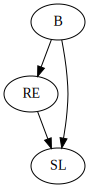

In [456]:
from causalgraphicalmodels import CausalGraphicalModel

Dag = CausalGraphicalModel(
    nodes=["SL","B","RE"], # Amusingly it spells DAG
    edges=[
        ("B","SL"),
        ("B", "RE"),
        ("RE","SL")
        
                
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
Dag.draw()

We can imagine that the brain size of a species determines the amount of research effort that goes into it. This could operate through some mechanism such as larger animals (which tend to have larger brains) being more attractive to us to study. (Read up on "charismatic megafauna if you doubt this https://en.wikipedia.org/wiki/Charismatic_megafauna#:~:text=Charismatic%20megafauna%20are%20large%20animal,%2C%20harp%20seal%2C%20and%20penguin.)

If this is the case, then a primate with a larger brain causes researchers to spend more time looking at them, and thus observing more social interactions. Research effort is not a confound in the usual sense of being a common cause of both brain size and observations of social learning, because it doesn't cause primate brain size. What research effort does is provide and indirect path to our observations which we do not care about. We care about the direct effect of primate brain size on the number of observations of social learning. When this is included in our model, then most of the data is really explained by the research effort. This not only makes sense causally, but is also validated by PSIS analysis below. The model including research effort isn't just a little bit better. It's far far superior at predicting the data.

In [459]:
az.compare({"With RE":H_11_6b_sample, "Without RE":H_11_6a_sample},scale ="deviance")

/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/stats/stats.py:682: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future rele

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
With RE,0,553.71,49.295,0,1,168.878,0,True,deviance
Without RE,1,1344.12,99.5778,790.408,1.32378e-46,396.121,339.422,True,deviance


# Other crazier ideas for 11H4

Once you've condition on the discipline, it doesn't appear to be the case that gender is hugely predictive of the department. There is certainly a skew in favour of the men. But the length scale is tiny, and the posterior is consistent with gender having no effect.

Now we need to go for the indirect effect that gender has on the grant application success. This is the effect of gender which is mediated by their discipline. Assuming the DAG I postulated at the beginning of this question is correct, to find the indirect effect, we must regress discipline against gender and then application success rate against discpline.

First we must measure the effect that gender has on the number of applications within each department. This can be done using a Poisson regression model. We can see that around 100s of applications were made by some departments so we'd like our priors to reflect that.

In [326]:
Grants[Grants.gender=="m"].awards.sum()/Grants[Grants.gender=="m"].applications.sum()

0.17737003058103976

In [327]:
Grants[Grants.gender=="f"].awards.sum()/Grants[Grants.gender=="f"].applications.sum()

0.14898989898989898

In [233]:
with pm.Model() as H_11_4_G_D_prior_test:
    a = pm.Normal("a", mu = 1, sigma = 2.5, shape = 1) 
    loglam = a 
    lam = pm.Deterministic("lam", pm.math.exp(loglam))
    y = pm.Poisson("y",lam, observed=Grants["applications"] )
    
    prior_sample = pm.sample_prior_predictive(samples = 1000, var_names=["a"])

INFO (theano.gof.compilelock): Refreshing lock /home/aidan/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.10-x86_64-3.8.5-64/lock_dir/lock


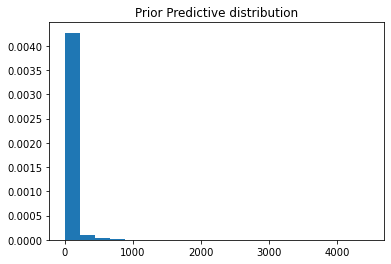

In [239]:
# sample the prior predictions
prior_predictive_sample = np.random.poisson(np.exp(prior_sample["a"]))

plt.hist(prior_predictive_sample, bins = 20, density=True)
plt.title("Prior Predictive distribution")

plt.show()

This prior gives us some coverage of the range 0 to 1000 applications, drastically losing probability mass after a couple of hundred applications, with some very wild outliers happening in the thousands. These outliers are sufficiently rare as to not matter. Let's run the model using these priors.

The model is of the form 

$ N $ ~ $ Poisson(\lambda)$

$ log(\lambda) = a + \mathbb{1}_{Gender}B_{CID}$

$a, b$ ~ $N(1,2.5)$

Where CID is the categorical index of the department.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /home/aidan/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.10-x86_64-3.8.5-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 20 seconds.
The number of effective samples is smaller than 10% for some parameters.


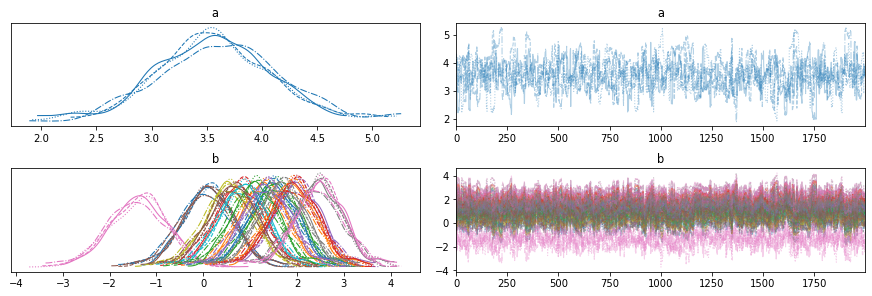

In [307]:
with pm.Model() as H_11_4_G_D:
    a = pm.Normal("a", mu = 1, sigma = 2.5, shape = 1) 
    b  = pm.Normal("b", mu = 1, sigma = 2.5, shape = (2,9))
    loglam = a + b[Grants.gender_idx,Grants.discipline_idx]
    lam = pm.Deterministic("lam", pm.math.exp(loglam))
    y = pm.Poisson("y",lam, observed=Grants.applications )
        
    #run MCMC
    H_11_4_G_D_sample = pm.sample(draws= 2000, chains = 4)
    pm.traceplot(H_11_4_G_D_sample, ["a","b"])

In [314]:
post_sample = np.random.poisson(H_11_4_G_D_sample["lam"])
post_sample_mean = post_sample.mean(axis=0)

In [315]:
intervals = pm.hpd(post_sample, hdi_prob=0.89)
errors = np.append((post_sample_mean.T - intervals[:,0]),(intervals[:,1] - post_sample_mean.T)).reshape(2,-1)

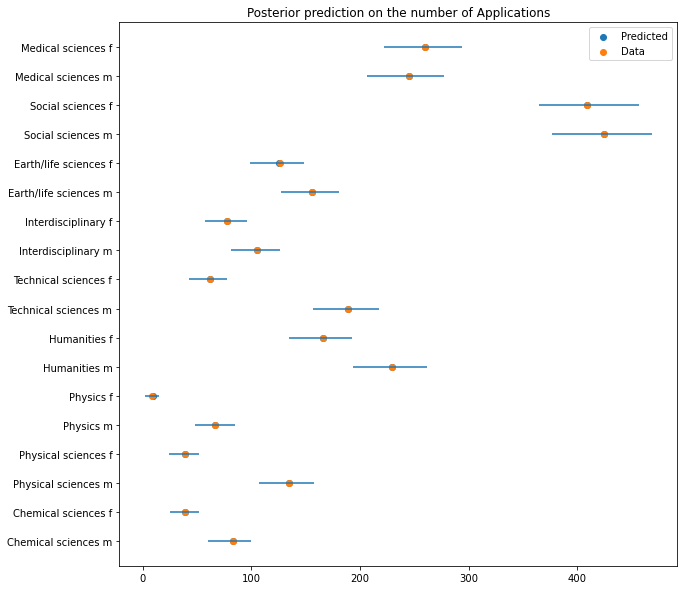

In [316]:
y = Grants["discipline"] + " " + Grants["gender"]
fig, ax = plt.subplots(figsize=(10,10))
#plot the posterior predictions
ax.scatter(post_sample_mean, y, label="Predicted")
ax.errorbar(post_sample_mean, y, xerr = errors, fmt=" ")

#plot the real data with an offset
ax.scatter(Grants["applications"],y, label="Data")

plt.legend()
plt.title("Posterior prediction on the number of Applications")
plt.show()

In [323]:
Grants[Grants["gender"] == "m"].awards.sum()/Grants[Grants["gender"] == "m"].applications.sum()

0.17737003058103976

In [324]:
Grants[Grants["gender"] == "f"].awards.sum()/Grants[Grants["gender"] == "f"].applications.sum()

0.14898989898989898

This model predicts quite well in and out of sample the number of counts expected.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.


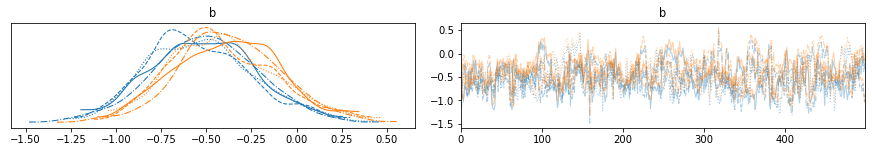

In [210]:
#model with discpline regressed against gender

with pm.Model() as H11_4_G_D:
    b  = pm.Normal("b", mu = 0, sigma = 1.5, shape =2) # gender predictor
    
    logitp = b[Grants.gender_idx]
    p_success = pm.Deterministic("p_success", pm.math.invlogit(logitp))
    y = pm.Binomial("y",n = Grants.applications, p=p_success, observed=Grants.awards )
    
    #get the quadratic approximation info
    approx_mean = pm.find_MAP()
    Hess = pm.find_hessian(approx_mean, vars=[b])
    
    #run MCMC
    H11_4_G_D_sample = pm.sample(draws= 500, chains = 4)
    pm.traceplot(H11_4_sample, ["b"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /home/aidan/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.10-x86_64-3.8.5-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 3 seconds.


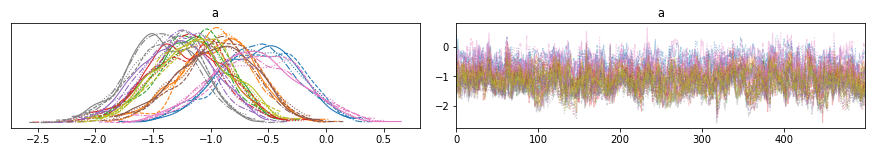

In [211]:
#model with application regressed against discpline

with pm.Model() as H11_4_D_A:
    a = pm.Normal("a", mu = 0, sigma = 1.5, shape = 9) # discipline predictor
    
    logitp = a[Grants.discipline_idx] 
    p_success = pm.Deterministic("p_success", pm.math.invlogit(logitp))
    y = pm.Binomial("y",n = Grants.applications, p=p_success, observed=Grants.awards )
    
    #get the quadratic approximation info
    approx_mean = pm.find_MAP()
    Hess = pm.find_hessian(approx_mean, vars=[a])
    
    #run MCMC
    H11_4_D_A_sample = pm.sample(draws= 500, chains = 4)
    pm.traceplot(H11_4_sample, ["a"])